<a href="https://colab.research.google.com/github/MasudRana2406/Integrating-Demand-Forecasting-and-Inventory-Optimization/blob/main/Retail_Demand_Forecasting_%26_Inventory_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Retail Demand Forecasting & Inventory Optimization (LSTM Model)
---------------------------------------------------------------
**Author:** Masud Rana

**Website:** https://data4fashion.com

**Goal:** Forecast future retail product sales using LSTM to support inventory optimization and reduce stockouts.

**Dataset:** M5 Forecasting - Walmart Sales (Kaggle) https://www.kaggle.com/competitions/m5-forecasting-accuracy

**Steps:**


1.   Import libraries
2.   Load & prepare dataset
1.   Exploratory analysis
2.   Prepare data for LSTM
1.   Build and train LSTM model
2.   Evaluate model and visualize forecast


### Import Required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os

### Load Dataset

In [3]:
# Check  files in folder
datasets_list = os.listdir('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/01. Masud Rana/m5-forecasting-accuracy')

for files in datasets_list:
  print(files)

calendar.csv
sales_train_evaluation.csv
sell_prices.csv
sample_submission.csv
sales_train_validation.csv





1.   **sales_train_validation.csv** which contain Historical daily unit sales of products in Walmart stores, so it is  our main file for building the forecasting model
2.  **calendar.csv** Contains dates, special events, and holidays which is useful for adding **time features** (day, month, events)
I will use these two files for my model building . Rest files are not relevant for my modelling

In [4]:
path = '/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/01. Masud Rana/m5-forecasting-accuracy'

calendar = pd.read_csv(os.path.join(path, 'calendar.csv'))
sales = pd.read_csv(os.path.join(path, 'sales_train_validation.csv'))

print("Sales shape:", sales.shape)
print("Calendar shape:", calendar.shape)

Sales shape: (30490, 1919)
Calendar shape: (1969, 14)


In [5]:
# Check Sales dataset
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [6]:
# Check calendar dataset
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [33]:
# Select Product & Display Information

# Choose which product row to forecast
row_num = 0  # to select another product this number should be changed
product_info = sales.iloc[row_num, :6]

print("\n🛒 Selected Product Details:")
print(product_info)

# Extract only sales columns (d_1 to d_1913)
sample_product = sales.iloc[row_num, 6:].astype(float)


🛒 Selected Product Details:
id          HOBBIES_1_001_CA_1_validation
item_id                     HOBBIES_1_001
dept_id                         HOBBIES_1
cat_id                            HOBBIES
store_id                             CA_1
state_id                               CA
Name: 0, dtype: object


In [34]:
# Align Calendar Dates with Sales Data

calendar_subset = calendar[['d', 'date']].copy()
calendar_subset['date'] = pd.to_datetime(calendar_subset['date'])

# The sales dataset has 1913 days (calendar has 1969)
valid_days = calendar_subset.iloc[:1913].copy()

# Combine into time-series DataFrame
sales_series = pd.DataFrame({
    'date': valid_days['date'],
    'sales': sample_product.values
})

print(f"\n✅ Sales time series created for {product_info['item_id']} | {len(sales_series)} days")



✅ Sales time series created for HOBBIES_1_001 | 1913 days


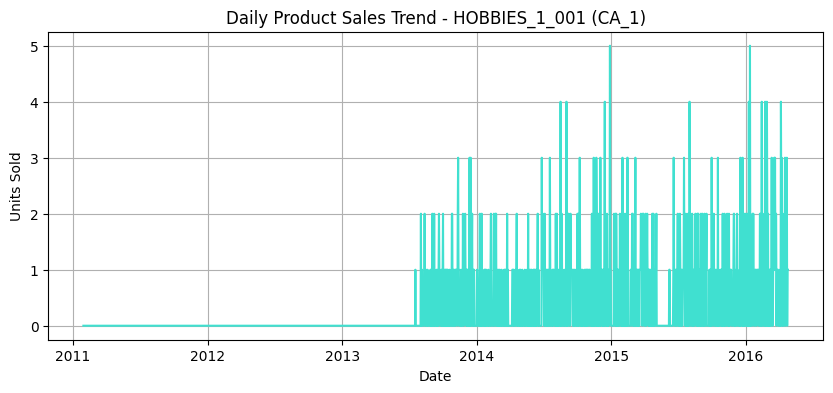

In [35]:
# Visualize the Sales Trend
plt.figure(figsize=(10, 4))
plt.plot(sales_series['date'], sales_series['sales'], color='turquoise')
plt.title(f"Daily Product Sales Trend - {product_info['item_id']} ({product_info['store_id']})")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.grid(True)
plt.show()


In [36]:
# Preprocess for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sales = scaler.fit_transform(sales_series[['sales']])

In [37]:
def create_sequences(data, window_size=30):
    """Create sequences for supervised LSTM learning."""
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [38]:
window_size = 30
X, y = create_sequences(scaled_sales, window_size)

In [39]:
# Split into train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 1506, Test samples: 377


In [40]:
# Build LSTM Model

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Train Model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0116 - val_loss: 0.0339
Epoch 2/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0096 - val_loss: 0.0336
Epoch 3/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0103 - val_loss: 0.0342
Epoch 4/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0103 - val_loss: 0.0334
Epoch 5/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0115 - val_loss: 0.0333
Epoch 6/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0122 - val_loss: 0.0344
Epoch 7/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0108 - val_loss: 0.0369
Epoch 8/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0128 - val_loss: 0.0347
Epoch 9/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0111 - val_loss: 0.0338
Epoch 10/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0114 - val_loss: 0.0335


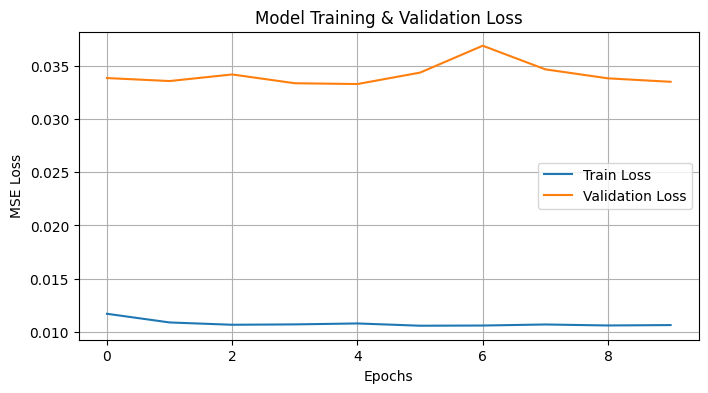

In [43]:
# Evaluate Model
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

In [44]:
# Predictions
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


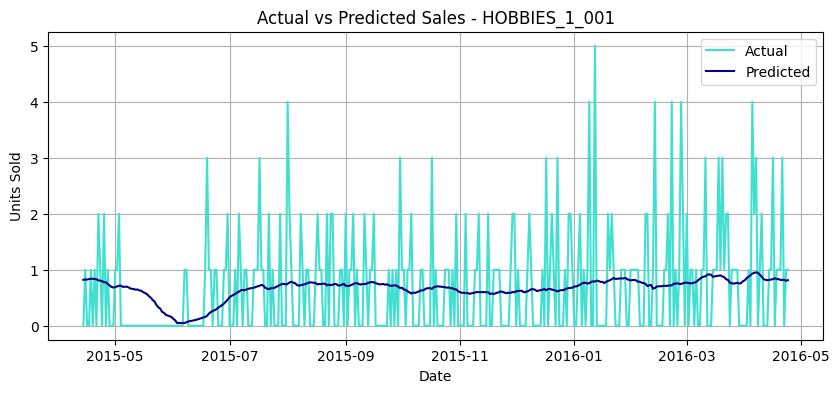

In [45]:
# Plot actual vs predicted
plt.figure(figsize=(10, 4))
plt.plot(sales_series['date'][-len(y_test):], y_test_inv, label='Actual', color='turquoise')
plt.plot(sales_series['date'][-len(y_test):], y_pred_inv, label='Predicted', color='navy')
plt.title(f"Actual vs Predicted Sales - {product_info['item_id']}")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.show()


📈 Next 30-Day Forecast:
        date  predicted_sales
0 2016-04-25         0.812739
1 2016-04-26         0.814462
2 2016-04-27         0.818318
3 2016-04-28         0.824071
4 2016-04-29         0.840133


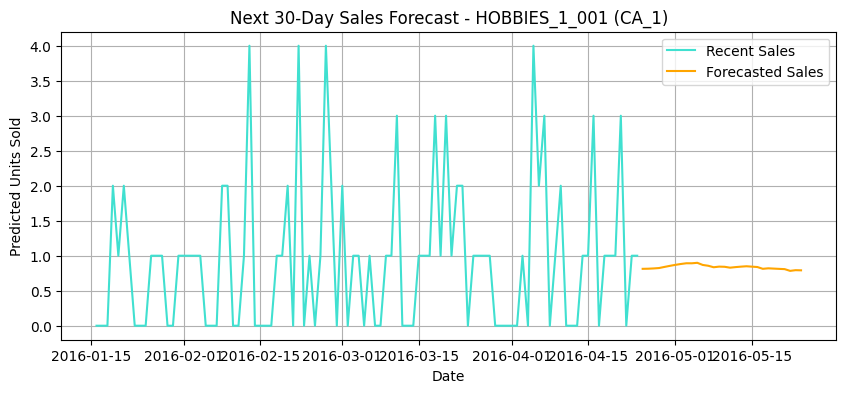


✅ LSTM Forecasting Completed Successfully!


In [46]:
# Forecast Next 30 Days

def forecast_future(model, data, steps=30):
    """Generate multi-step forecasts from the trained model."""
    predictions = []
    current_batch = data[-window_size:].reshape((1, window_size, 1))
    for _ in range(steps):
        pred = model.predict(current_batch, verbose=0)[0]
        predictions.append(pred)
        current_batch = np.append(current_batch[:, 1:, :], [[pred]], axis=1)
    return scaler.inverse_transform(predictions)

future_days = 30
future_forecast = forecast_future(model, scaled_sales, steps=future_days)

future_dates = pd.date_range(sales_series['date'].iloc[-1] + pd.Timedelta(days=1), periods=future_days)

# Create DataFrame for forecast results
forecast_df = pd.DataFrame({
    'date': future_dates,
    'predicted_sales': future_forecast.flatten()
})

print("\n📈 Next 30-Day Forecast:")
print(forecast_df.head())

# Plot future forecast
plt.figure(figsize=(10, 4))
plt.plot(sales_series['date'][-100:], sales_series['sales'][-100:], label='Recent Sales', color='turquoise')
plt.plot(future_dates, forecast_df['predicted_sales'], label='Forecasted Sales', color='orange')
plt.title(f"Next 30-Day Sales Forecast - {product_info['item_id']} ({product_info['store_id']})")
plt.xlabel("Date")
plt.ylabel("Predicted Units Sold")
plt.legend()
plt.grid(True)
plt.show()

print("\n✅ LSTM Forecasting Completed Successfully!")

In [47]:
forecast_df.to_csv('forecast_next_30_days.csv', index=False)
